In [4]:
!pip install tensorflow opencv-python matplotlib

  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached matplotlib-3.10.1-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached termcolor-3.0.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.17.2-cp310-cp310-win_amd64.whl.metadata (6.5 kB

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')


[]

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'Annotations/emotion_classes'
image_exts = ['jpeg','jpg', 'bmp', 'png']


In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

KeyboardInterrupt: 

In [8]:

import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('Annotations/emotion_classes')


Found 39407 files belonging to 26 classes.


In [10]:
data_iterator = data.as_numpy_iterator()


In [11]:
batch = data_iterator.next()


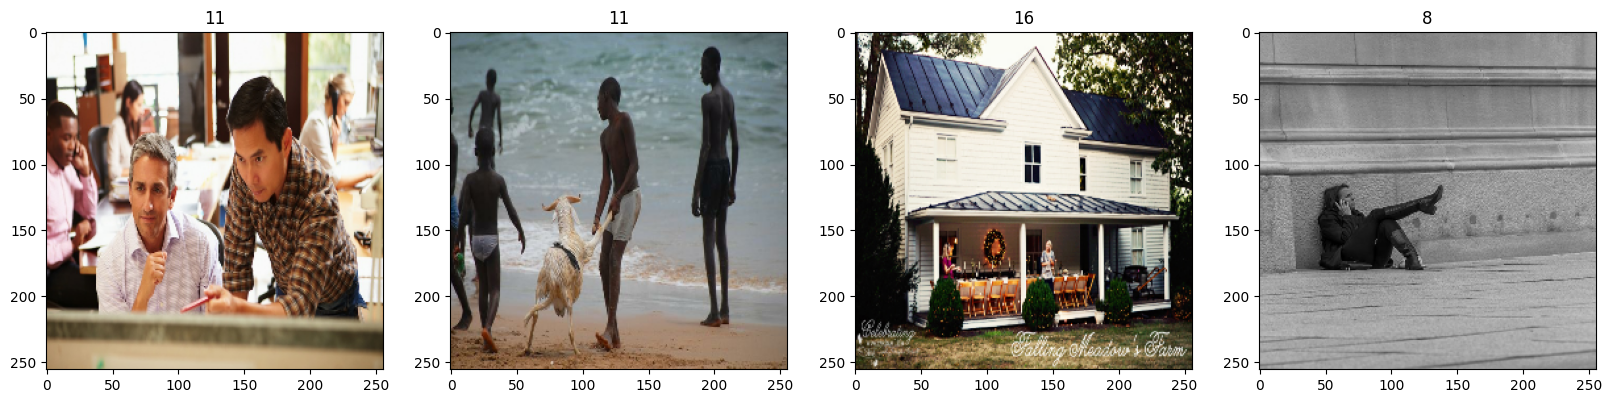

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()


(array([[[[2.35412759e-03, 2.35412759e-03, 2.35412759e-03],
          [2.29449011e-03, 2.29449011e-03, 2.29449011e-03],
          [2.30836705e-03, 2.30836705e-03, 2.30836705e-03],
          ...,
          [2.42496864e-03, 2.42496864e-03, 2.42496864e-03],
          [2.40754755e-03, 2.40754755e-03, 2.40754755e-03],
          [2.07528332e-03, 2.07528332e-03, 2.07528332e-03]],
 
         [[2.27245851e-03, 2.27245851e-03, 2.27245851e-03],
          [2.32233386e-03, 2.32233386e-03, 2.32233386e-03],
          [2.36804946e-03, 2.36804946e-03, 2.36804946e-03],
          ...,
          [2.39036675e-03, 2.39036675e-03, 2.39036675e-03],
          [2.41184281e-03, 2.41184281e-03, 2.41184281e-03],
          [2.11895653e-03, 2.11895653e-03, 2.11895653e-03]],
 
         [[2.39958777e-03, 2.39958777e-03, 2.39958777e-03],
          [2.33065407e-03, 2.33065407e-03, 2.33065407e-03],
          [2.35678582e-03, 2.35678582e-03, 2.35678582e-03],
          ...,
          [2.33654142e-03, 2.33654142e-03, 2.3365

In [15]:
train_size = int(len(data)*.3)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train_size


369

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Multiply, Reshape

# ---------- Custom Layers ----------

# 1. AttentionModule: a channel-based attention module (Squeeze-and-Excitation style)
class AttentionModule(tf.keras.layers.Layer):
    def __init__(self, filters, reduction=8, **kwargs):
        """
        filters: number of input filters
        reduction: reduction ratio for bottleneck in the attention module
        """
        super(AttentionModule, self).__init__(**kwargs)
        self.filters = filters
        self.reduction = reduction
        self.gap = GlobalAveragePooling2D()
        self.fc1 = Dense(filters // reduction, activation='relu')
        self.fc2 = Dense(filters, activation='sigmoid')
        self.reshape = Reshape((1, 1, filters))
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.gap(inputs)                   # Squeeze: shape (batch, filters)
        x = self.fc1(x)                        # Bottleneck layer with ReLU
        x = self.fc2(x)                        # Scale factors with sigmoid activation
        x = self.reshape(x)                    # Reshape to (batch, 1, 1, filters)
        return self.multiply([inputs, x])      # Recalibrate the channels

# 2. ContextModule: a spatial attention module to emphasize relevant regions in the feature map
class ContextModule(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ContextModule, self).__init__(**kwargs)
        # Here we use a 1x1 convolution with a sigmoid activation to form a spatial attention mask.
        self.conv = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')

    def call(self, inputs):
        # The attention mask is generated from the input feature map.
        attention_map = self.conv(inputs)   # shape: (batch, H, W, 1)
        return inputs * attention_map         # Multiply element-wise to emphasize key regions

# ---------- Build the Model ----------

def build_emotion_model(input_shape=(256, 256, 3), num_classes=26):
    inputs = Input(shape=input_shape)

    # --- Block 1: Low-level feature extraction ---
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)
    # Add Attention & Context to emphasize important channels and spatial features.
    x = AttentionModule(32)(x)
    x = ContextModule()(x)

    # --- Block 2: Mid-level feature extraction ---
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)
    x = AttentionModule(64)(x)
    x = ContextModule()(x)

    # --- Block 3: High-level feature extraction ---
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)
    x = AttentionModule(128)(x)
    x = ContextModule()(x)

    # --- Block 4: Further high-level feature extraction ---
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)
    x = AttentionModule(256)(x)
    x = ContextModule()(x)

    # --- Fully Connected Layers ---
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    # For multi-class classification, we use softmax activation.
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ---------- Compile the Model ----------

model = build_emotion_model()

model.compile(
    loss='categorical_crossentropy',   # Use categorical_crossentropy for multi-class (26 emotions)
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_module                │ (None, 128, 128, 32)   │           292 │
│ (AttentionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ context_module (ContextModule)  │ (None, 128, 128, 32)   │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_module_1              │ (None, 64, 64, 64)     │         1,096 │
│ (AttentionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ context_module_1                │ (None, 64, 64, 64)     │            65 │
│ (ContextModule)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           51

 Total params: 34,767,162 (132.63 MB)

 Trainable params: 34,765,242 (132.62 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [18]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [19]:
model.compile(
    loss='sparse_categorical_crossentropy',  # For integer labels.
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
 32/369 ━━━━━━━━━━━━━━━━━━━━ 18:27 3s/step - accuracy: 0.2440 - loss: 2.6195